# Case1: HTTPリクエストの中身

In [1]:
var dbg = new Debugger("localhost", 25432);  // JDIを使用

>> Debugger Info: Try to connect to localhost:25432
>> Debugger Info: Successflly connected to localhost:25432


In [2]:
dbg.run();
Point p = dbg.stopAt("tomcatdemo.App", 18).get(); // 18行目で停止

>> Debugger Info: Debugger started.


http://localhost:8080/TomcatDemo-0.0.1/home にGoogle Chromeから1回アクセス

In [3]:
DebugResult dr = p.getResults().get("req");
var req = (ObjectInfo) dr.getLatestValue(); // 変数reqの値を取得

In [4]:
req.invokeMethod(dbg.thread(), "getMethod");  // HTTPメソッド

return of getMethod="GET"


In [5]:
req.invokeMethod(dbg.thread(), "getRequestURI"); // リクエストURI

return of getRequestURI="/TomcatDemo-0.0.1/home"


In [6]:
req.invokeMethod(dbg.thread(), "getHeader", "User-Agent"); // User-Agentヘッダ

return of getHeader="Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.141 Safari/537.36"


# Case2: ボトルネックの特定

In [1]:
var dbg = new Debugger("localhost", 39876, true); // ProbeJを使用

In [2]:
dbg.run();
String[] vars = {"noOfViews"};
var points = new ArrayList<Point>();
int[] lines = {18, 20, 22, 24, 26};
Arrays.stream(lines).forEach(line -> {
  points.add(dbg.watch("tomcatdemo.App", line, vars).get());
})

Try to connect to localhost:39876
Succeccfully connected to localhost:39876
>> Debugger Info: Debugger started.


http://localhost:8080/TomcatDemo-0.0.1/home に1回アクセス

In [3]:
var values =  new ArrayList<ValueInfo>();
points.forEach(p -> {
  var dr = p.getResults().get(vars[0]);
  values.add(dr.getLatestValue());
  println("value\t:\ttimestamp");
  dr.getValues().forEach(val -> {
    println(val.getValue()+"\t:\t"+val.getCreatedAt());
  }); 
})

value	:	timestamp
0	:	2021-01-25T16:19:14.963
value	:	timestamp
0	:	2021-01-25T16:19:15.265
value	:	timestamp
0	:	2021-01-25T16:19:15.375
value	:	timestamp
0	:	2021-01-25T16:19:20.382
value	:	timestamp
0	:	2021-01-25T16:19:20.598


302.0
110.0
5007.0
216.0


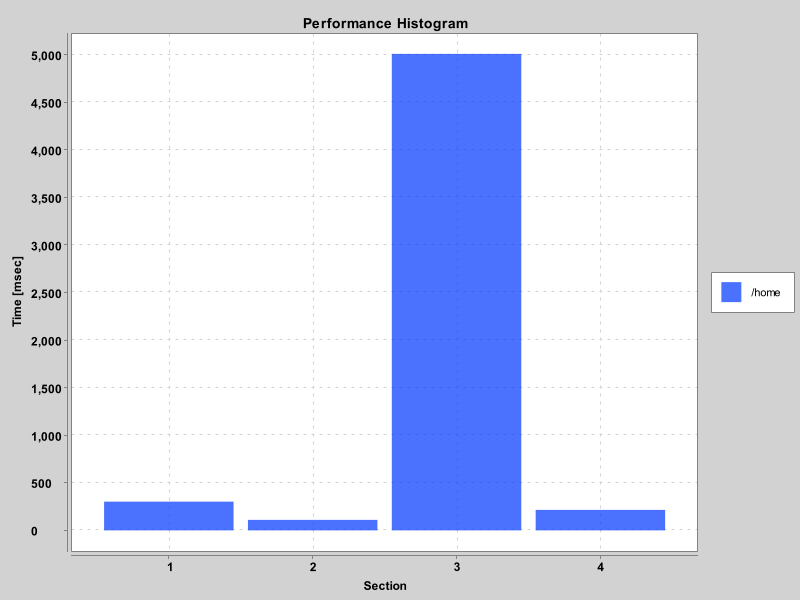

In [4]:
import java.time.temporal.ChronoUnit;

var x = new ArrayList<Double>();
var y = new ArrayList<Double>();

// データの整形
for (int i = 0; i < values.size()-1; i++) {
  x.add((double) i+1);
  y.add((double) (ChronoUnit.MILLIS.between(values.get(i).getCreatedAt(), values.get(i+1).getCreatedAt())));
  println(y.get(i));
}

// 図の生成
CategoryChart chart = new CategoryChartBuilder().width(800).height(600).title("Performance Histogram")
                                                .xAxisTitle("Section").yAxisTitle("Time [msec]").build();
// Series
chart.addSeries("/home", x, y);
BitmapEncoder.getBufferedImage(chart);

In [5]:
dbg.exit();

>> Debugger Info: Debugger exited.
